In [11]:
import pandas as pd
import numpy as np

# make sure the aps module is in the pythonpath
import sys
from pathlib import Path

APS_dir = str(Path.cwd().parents[1])
if APS_dir not in sys.path:
    sys.path.append(APS_dir)
import aps.aps_io.get_forecasts as gf # replace with varsomdata-class

#import aps.config.training_score as ts
from aps.config.training_score import APSTrainingScore

In [27]:
import flatten_json

# Get API data
Request necessary data from https://api01.nve.no/hydrology/forecast/avalanche/v4.0.0/api

Explanation at http://api.nve.no/doc/snoeskredvarsel/#format

Insert relevant data into SQLite database.

General:
- date
- region
- region-ID
- danger level

Avalanche problem:
- avalanche problem name
- avalanche problem order
- trigger
- probability
- elevation

Mountain weather:
- avg. precipitation
- max precipitation (most exposed area)
- temperature (at diff. levels)
- wind speed
- wind direction

In [12]:
warnings, url = gf.get_warnings_as_json([3022, 3023, 3024], "2017-12-01", "2018-05-31", lang_key=1, simple=False, recursive_count=5)
print(url)

df = pd.DataFrame(warnings)
df.head(5)

https://api01.nve.no/hydrology/forecast/avalanche/v4.0.0/api/AvalancheWarningByRegion/Detail/3024/1/2017-12-01/2018-05-31


,Author,AvalancheDanger,AvalancheProblems,CountyList,CurrentWeaklayers,DangerLevel,DangerLevelName,EmergencyWarning,LangKey,LatestAvalancheActivity,...,RegionId,RegionName,RegionTypeId,RegionTypeName,SnowSurface,UtmEast,UtmNorth,UtmZone,ValidFrom,ValidTo
0,Karsten@NVE,Forholdene er generelt stabile. I noen definer...,"[{'AvalancheProblemId': 1, 'AvalancheExtId': 2...","[{'Id': '15', 'Name': 'Møre og Romsdal'}, {'Id...",Snødekket fremstår som stabilt. Lommer av fok...,1,1 Liten,Ikke gitt,1,Det er ikke observert nevneverdig skredaktivit...,...,3022,Trollheimen,10,A,Mildvær har komprimert snødekket og dannet tyd...,210810,6991060,33,2017-12-01T00:00:00,2017-12-01T23:59:59
1,Jørgen@obskorps,Det forventes at snødekket under mildværsgrens...,"[{'AvalancheProblemId': 1, 'AvalancheExtId': 2...","[{'Id': '15', 'Name': 'Møre og Romsdal'}, {'Id...",Snødekket fremstår som stabilt. Lommer av fok...,2,2 Moderat,Ikke gitt,1,Det er ikke observert nevneverdig skredaktivit...,...,3022,Trollheimen,10,A,Mildvær har komprimert snødekket og dannet tyd...,210810,6991060,33,2017-12-02T00:00:00,2017-12-02T23:59:59
2,Jørgen@obskorps,Vind og godt med snø vil føre til dannelse av ...,"[{'AvalancheProblemId': 1, 'AvalancheExtId': 2...","[{'Id': '15', 'Name': 'Møre og Romsdal'}, {'Id...",Snødekket fremstår som stabilt.,3,3 Betydelig,Ikke gitt,1,Det er ikke observert nevneverdig skredaktivit...,...,3022,Trollheimen,10,A,Snødekket har blitt påvirket av mildvær i fler...,210810,6991060,33,2017-12-03T00:00:00,2017-12-03T23:59:59
3,Jørgen@obskorps,Vind og pågående snøvær vil føre til ytterlige...,"[{'AvalancheProblemId': 1, 'AvalancheExtId': 2...","[{'Id': '15', 'Name': 'Møre og Romsdal'}, {'Id...",Rundt skarelag nede i snødekket er kantkorndan...,3,3 Betydelig,Ikke gitt,1,Det er ikke rapportert om nevneverdig skredakt...,...,3022,Trollheimen,10,A,Snødekket har blitt påvirket av mildvær i fler...,210810,6991060,33,2017-12-04T00:00:00,2017-12-04T23:59:59
4,torolav@obskorps,Kraftig vind og nedbør over tid gir store meng...,"[{'AvalancheProblemId': 2, 'AvalancheExtId': 2...","[{'Id': '15', 'Name': 'Møre og Romsdal'}, {'Id...",Rundt skarelag nede i snødekket er kantkorndan...,3,3 Betydelig,Ikke gitt,1,Det er ikke rapportert om nevneverdig skredakt...,...,3022,Trollheimen,10,A,Snødekket har blitt påvirket av mildvær i fler...,210810,6991060,33,2017-12-05T00:00:00,2017-12-05T23:59:59


In [13]:
print(df['AvalancheProblems'][3])

[{'AvalancheProblemId': 1, 'AvalancheExtId': 20, 'AvalancheExtName': 'Tørre flakskred', 'AvalCauseId': 11, 'AvalCauseName': 'Nedsnødd eller nedføyket overflaterim', 'AvalProbabilityId': 3, 'AvalProbabilityName': 'Mulig ', 'AvalTriggerSimpleId': 21, 'AvalTriggerSimpleName': 'Liten tilleggsbelastning', 'DestructiveSizeExtId': 3, 'DestructiveSizeExtName': '3 - Middels', 'AvalPropagationId': 2, 'AvalPropagationName': 'Noen bratte heng', 'AvalancheAdvice': 'Unngå ferdsel i skredterreng og i utløpsområder. Det er størst sjanse for å løse ut skred der snødekket er tynt, nær rygger og framstikkende steiner. Fjernutløsning er sannsynlig. Det krever mye kunnskap å gjenkjenne svake lag i snødekket. Drønnelyder og skytende sprekker er tydelige tegn, men fravær av slike tegn betyr ikke at det er trygt. Vær ekstra forsiktig etter snøfall eller vind og i perioder med temperaturstigning.', 'AvalancheTypeId': 10, 'AvalancheTypeName': 'Flakskred', 'AvalancheProblemTypeId': 30, 'AvalancheProblemTypeName'

In [14]:
df_a = df

In [15]:

# define individual columns for avalanche problem 1 (AP1)
df_a['AP1.AvalCauseId'] = np.nan
df_a['AP1.AvalCauseName'] = ''
df_a['AP1.AvalancheProblemTypeId'] = np.nan # AvalancheProblemTypeId
df_a['AP1.AvalancheProblemTypeName'] = '' # AvalancheProblemTypeName
df_a['AP1.DestructiveSizeExtId'] = np.nan # DestructiveSizeExtId
df_a['AP1.DestructiveSizeExtName'] = ''
df_a['AP1.AvalancheProblemId'] = np.nan
df_a['AP1.AvalancheTypeId'] = np.nan
df_a['AP1.AvalancheTypeName'] = ''
df_a['AvalProbabilityId'] = np.nan
df_a['AvalProbabilityName'] = ''
df_a['AvalPropagationId'] = np.nan
df_a['AvalPropagationName'] = ''
df_a['AvalTriggerSimpleId'] = np.nan
df_a['AvalTriggerSimpleName'] = ''

df_a['AP1.Score'] = np.nan # APS score defined in /config/traininng_score.json and config/test_training_score.py
#df_a.columns

In [16]:
#df_a['MountainWeather'][23]

In [17]:
beaufort_scale = {'Stille/svak vind': 2, 'Bris': 4, 'Frisk bris': 5, 'Liten kuling': 6, 'Stiv kuling': 7, 'Sterk kuling': 8, 'Liten storm': 9, 'Storm': 10, 'Orkan': 12}

See full list at http://api.nve.no/doc/snoeskredvarsel/#format

- Precipitation (most exposed): MeasurementType=10; MeasurementSubType=60
- Wind speed: MeasurementType=20; MeasurementSubType=20
- Wind direction: MeasurementType=20; MeasurementSubType=50

In [18]:
# define columns for meteorological parameters
df_a['Regional.PrecipitationMostExposed'] = np.nan
df_a['Regional.PrecipitationAverage'] = np.nan
df_a['Regional.WindSpeed'] = ''
df_a['Regional.WindDirection'] = ''

#df_a.columns

In [19]:
for index, row in df_a.iterrows():
    for mt in row['MountainWeather']['MeasurementTypes']:
        #print(mt)
        if mt['Id']==20: # wind
            #print(mt['Name'])
            for st in mt['MeasurementSubTypes']:
                if st['Id'] == 20:
                    df_a.loc[index, 'Regional.WindSpeed'] = beaufort_scale[st['Value']]
                if st['Id'] == 50:
                    df_a.loc[index, 'Regional.WindDirection'] = st['Value']
        if mt['Id']==10: # precip
            for st in mt['MeasurementSubTypes']:
                if st['Id'] == 60:
                    df_a.loc[index, 'Regional.PrecipitationMostExposed'] = st['Value']
                if st['Id'] == 70:
                    df_a.loc[index, 'Regional.PrecipitationAverage'] = st['Value']
            #print(mt['Name'])

        
    for i in range(len(row['AvalancheProblems'])):
        column_name_prefix = "AP{0}".format(row['AvalancheProblems'][i]['AvalancheProblemId'])
        df_a.loc[index, '{0}.AvalCauseId'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalCauseId']
        df_a.loc[index, '{0}.AvalCauseName'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalCauseName']
        df_a.loc[index, '{0}.AvalancheProblemTypeId'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalancheProblemTypeId']
        df_a.loc[index, '{0}.AvalancheProblemTypeName'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalancheProblemTypeName']
        df_a.loc[index, '{0}.DestructiveSizeExtId'.format(column_name_prefix)] = row['AvalancheProblems'][i]['DestructiveSizeExtId']
        df_a.loc[index, '{0}.DestructiveSizeExtName'.format(column_name_prefix)] = row['AvalancheProblems'][i]['DestructiveSizeExtName']
        df_a.loc[index, '{0}.AvalancheProblemId'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalancheProblemId']
        df_a.loc[index, '{0}.AvalancheTypeId'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalancheTypeId']
        df_a.loc[index, '{0}.AvalancheTypeName'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalancheTypeName']
        df_a.loc[index, '{0}.AvalProbabilityId'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalProbabilityId']
        df_a.loc[index, '{0}.AvalProbabilityName'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalProbabilityName']
        df_a.loc[index, '{0}.AvalPropagationId'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalPropagationId']
        df_a.loc[index, '{0}.AvalPropagationName'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalPropagationName']
        df_a.loc[index, '{0}.AvalTriggerSimpleId'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalTriggerSimpleId']
        df_a.loc[index, '{0}.AvalTriggerSimpleName'.format(column_name_prefix)] = row['AvalancheProblems'][i]['AvalTriggerSimpleName']
        

In [20]:
df_a['Regional.WindSpeed'].unique()

array([ 4,  6,  5,  8,  7, 10,  9,  2], dtype=int64)

### List relevant parameters for the regression analysis

In [21]:
# get_score(position, size, distribution, trigger, probability, dangerlevel)
ts = APSTrainingScore()
print(ts.score_dict)
print(ts.score_dict['DangerLevel'][str(int(df_a['DangerLevel'][1]))])

{'AvalancheProblemId': {'1': 4, '2': 2, '3': 1}, 'AvalTriggerSimpleId': {'22': 3, '21': 2, '10': 1, '0': 0}, 'DestructiveSizeExtId': {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}, 'DangerLevel': {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}, 'AvalProbabilityId': {'7': 4, '5': 3, '3': 2, '2': 1, '0': 0}, 'AvalPropagationId': {'5': 5, '4': 4, '3': 3, '2': 2, '1': 1, '0': 0}}
2


In [22]:
for index, row in df_a.iterrows():
    ts.get_score(row['AP1.AvalancheProblemId'],
                row['AP1.DestructiveSizeExtId'],
                row['AP1.AvalPropagationId'],
                row['AP1.AvalTriggerSimpleId'],
                row['AP1.AvalProbabilityId'],
                row['DangerLevel'])
    df_a.loc[index, 'AP1.Score'] = ts.score

## Clean and save dataframe

In [24]:
df_a.columns

Index(['Author', 'AvalancheDanger', 'AvalancheProblems', 'CountyList',
       'CurrentWeaklayers', 'DangerLevel', 'DangerLevelName',
       'EmergencyWarning', 'LangKey', 'LatestAvalancheActivity',
       'LatestObservations', 'MainText', 'MountainWeather', 'MunicipalityList',
       'NextWarningTime', 'PreviousWarningRegId', 'PublishTime', 'RegId',
       'RegionId', 'RegionName', 'RegionTypeId', 'RegionTypeName',
       'SnowSurface', 'UtmEast', 'UtmNorth', 'UtmZone', 'ValidFrom', 'ValidTo',
       'AP1.AvalCauseId', 'AP1.AvalCauseName', 'AP1.AvalancheProblemTypeId',
       'AP1.AvalancheProblemTypeName', 'AP1.DestructiveSizeExtId',
       'AP1.DestructiveSizeExtName', 'AP1.AvalancheProblemId',
       'AP1.AvalancheTypeId', 'AP1.AvalancheTypeName', 'AvalProbabilityId',
       'AvalProbabilityName', 'AvalPropagationId', 'AvalPropagationName',
       'AvalTriggerSimpleId', 'AvalTriggerSimpleName', 'AP1.Score',
       'Regional.PrecipitationMostExposed', 'Regional.PrecipitationAverage',

In [25]:
df_a = df_a.drop(['CountyList', 'MunicipalityList'], axis=1)

In [26]:
df_a.to_csv('varsel_nordvestlandet_17_18.csv')

## Plotting

In [22]:
import matplotlib.pyplot as plt

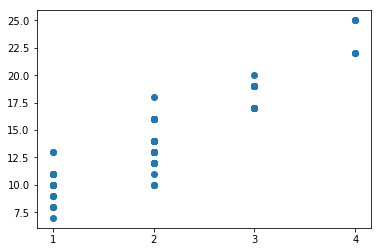

In [28]:
plt.scatter(df_a['DangerLevel'], df_a['AP1.Score'])

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
df_ws = df_a[df_a['AP1.ProblemTypeId'] == 10.0]

In [ ]:
dl1 = go.Scatter(x = df_ws[df_ws["DangerLevel"] == '1']['Regional.PrecipitationMostExposed'], y = df_ws[df_ws["DangerLevel"] == '1']['Regional.WindSpeed'], name="Lowdanger", mode='markers',
                marker = {'size': 10, 'color': 'green'})
dl2 = go.Scatter(x = df_ws[df_ws["DangerLevel"] == '2']['Regional.PrecipitationMostExposed'], y = df_ws[df_ws["DangerLevel"] == '2']['Regional.WindSpeed'], name="Moderate danger", mode='markers',
                marker = {'size': 10, 'color': 'yellow'})
dl3 = go.Scatter(x = df_ws[df_ws["DangerLevel"] == '3']['Regional.PrecipitationMostExposed'], y = df_ws[df_ws["DangerLevel"] == '3']['Regional.WindSpeed'], name="Considerable danger", mode='markers',
                marker = {'size': 10, 'color': 'orange'})
dl4 = go.Scatter(x = df_ws[df_ws["DangerLevel"] == '4']['Regional.PrecipitationMostExposed'], y = df_ws[df_ws["DangerLevel"] == '4']['Regional.WindSpeed'], name="High danger", mode='markers',
                marker = {'size': 10, 'color': 'red'})
dl = go.Scatter(x = df_a['Regional.PrecipitationMostExposed'], y = df_a['Regional.WindSpeed'], name="All danger+problems", mode='markers',
                marker = {'size': 10, 'color': 'black'})
# Edit the layout
layout = dict(title = 'Wind vs. precipitation (wind slabs)',
              xaxis = dict(title = 'Precipitation'),
              yaxis = dict(title = 'Wind speed'),
              )
pltdata = [dl, dl1, dl2, dl3, dl4]
fig = dict(data=pltdata, layout=layout)

py.iplot(fig, filename='precip_wind_dangerlevel')

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
### For the purposes of this example, we store feature data from our
### dataframe `df`, in the `f1` and `f2` arrays. We combine this into
### a feature matrix `X` before entering it into the algorithm.
f1 = np.array(df_a['Regional.PrecipitationMostExposed'].values, dtype=int)
f2 = np.array(df_a['Regional.WindSpeed'].values)
f3 = np.array(df_a['AP1.ProblemTypeId'].values)

X = np.dstack((f1, f2, f3))[0]
#print(X)
kmeans = KMeans(n_clusters=4).fit(X)

In [ ]:
kmeans.labels_
#print(len(kmeans.labels_), len(f1), len(f2))

In [ ]:
dl_class = go.Scatter(x = f1, y = f2, name="k-means classified", mode='markers',
                marker = {'size': 10, 'color': kmeans.labels_})
# Edit the layout
layout = dict(title = 'Wind vs. precipitation - classified',
              xaxis = dict(title = 'Precipitation'),
              yaxis = dict(title = 'Wind speed'),
              )
class_data = [dl_class]
fig = dict(data=class_data, layout=layout)

py.iplot(fig, filename='class_precip_wind_dangerlevel')

In [ ]:
dl_f3 = go.Scatter(x = f1, y = f2, name="k-means classified", mode='markers',
                marker = {'size': 10, 'color': f3})
# Edit the layout
layout = dict(title = 'Wind vs. precipitation - AP1-colored',
              xaxis = dict(title = 'Precipitation'),
              yaxis = dict(title = 'Wind speed'),
              )
ap1_data = [dl_f3]
fig = dict(data=ap1_data, layout=layout)

py.iplot(fig, filename='precip_wind_AP1')

In [ ]:
import requests


# http://tst-h-int-api01/APSServices/TimeSeriesReader.svc/DistributionByDate/met_obs_v2.0/<værparameter>/24/<regions_id>.0/<fra_dato>/<til_dato>
#met_url = r"http://h-web03.nve.no/APSapi/TimeSeriesReader.svc/PrecipitationByDate/met_obs_v2.0/0/24/3024.0/2018-03-04/2018-03-04"
met_url = r'http://h-web03.nve.no/APSapi/TimeSeriesReader.svc/MountainWeather/3024.0/2018-03-04/no/true'
met_data = requests.get(met_url).json()
print(met_data)
df_met = pd.DataFrame(met_data)
print(df_met)

### Decision trees

In [ ]:
from sklearn import tree
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)
clf.predict([[1, 1]])